## Import Packages

In [5]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Utility functions for camera calibration

In [13]:
def find_chessboard_corners(img, rows, cols):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((rows*cols,3), np.float32)
    objp[:,:2] = np.mgrid[0:cols, 0:rows].T.reshape(-1,2)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (cols, rows), None)
    
    if ret == True:
        return objp, corners
    else:
        return None

def calibrate_camera(filenames, rows, cols):
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    img_size = None

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(filenames):
        img = cv2.imread(fname)
        
        # Assume calibration and test images have the same dimensions!
        if img_size is None:
            img_size = (img.shape[1], img.shape[0])

        res = find_chessboard_corners(img, rows, cols)
        if res is not None:   
            objp, corners = res
            objpoints.append(objp)
            imgpoints.append(corners)
        else:
            print(fname)

    # Do camera calibration given object points and image points
    return cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

## Extract object points and image points for camera calibration

['camera_cal/calibration2.jpg']


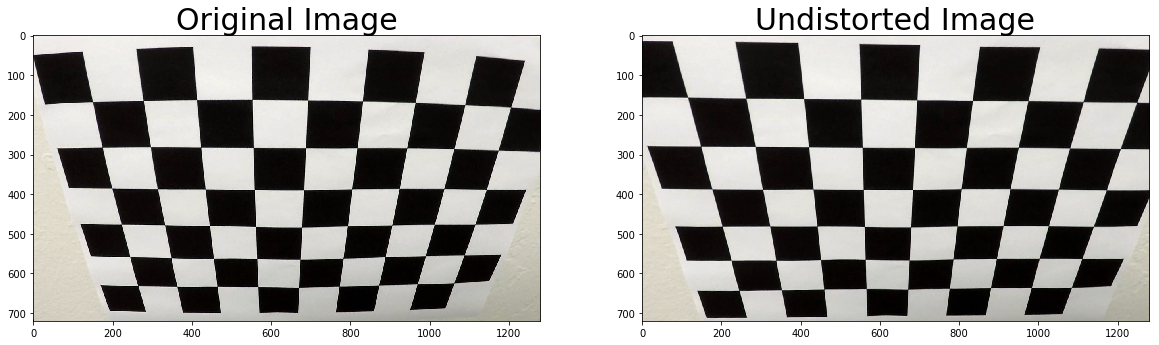

In [15]:
# Define chessboard size
rows = 6
cols = 9

# Make a list of calibration images
#images = glob.glob('camera_cal/calibration*.jpg')
images = ['camera_cal/calibration2.jpg']

print(images)

# Get calibration params
ret, mtx, dist, rvecs, tvecs = calibrate_camera(images, rows, cols)

# Test undistortion on an image
#img = cv2.imread('test_images/test1.jpg')
img = cv2.imread('camera_cal/calibration2.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)